In [1]:
import os
from os import path
import sys
import random
from itertools import chain, product

import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader
from torch.utils.data.sampler import Sampler
from torchvision.datasets import CIFAR10
from torchvision import transforms as transforms

sys.path.append(path.dirname(path.abspath('')))
from models.wideresnet import WideResNet
from metrics.similarity import kernel_CKA, linear_CKA

In [2]:
def find_ckpt(expname, comm, modeldir='../ckpt', epoch=None, client=None):
    f = filter(lambda x: expname in x, os.listdir(modeldir))
    f = filter(lambda x: f'comm{comm:03}' in x, f)
    if client is None:
        f = filter(lambda x: f'GLOBAL' in x, f)
    else:
        if epoch:
            f = filter(lambda x: f'epoch{epoch:03}' in x, f)
        f = filter(lambda x: f'CLIENT{client:02}' in x, f)
    return list(f)[0]

def extract_repr(model, loader, layers, device):
    reprs = []
    def hook(module, input_, output):
        reprs.append(output)
    assert layers is not None
    modules = [v for k, v in model.named_modules() if k in layers]
    for module in modules:
        module.register_forward_hook(hook)
    with torch.no_grad():
        for data, target in loader:
            if device:
                model = model.to(device)
                data = data.to(device)
            model(data)
    return reprs

In [3]:
class UniformSampler(Sampler):
    def __init__(self, data_source, n_each=1, seed=42, shuffle=True):
        self.data_target= list(zip(data_source.data, data_source.targets))
        self.n_classes = len(data_source.classes)
        self.n_each = n_each
        st = np.random.get_state()
        np.random.seed(seed)
        indices = [np.where(np.array(testset.targets)==i)[0] for i in range(self.n_classes)]
        for idx in indices:
            np.random.shuffle(idx)
        self.indices = list(chain(*[idx[:n_each] for idx in indices]))
        if shuffle:
            np.random.shuffle(self.indices)
        np.random.set_state(st)
    def __iter__(self):
        return (idx for idx in self.indices)
    def __len__(self):
        return self.n_classes*self.n_each

In [4]:
testset = CIFAR10('~/data', train=False, transform=transforms.ToTensor())
loader = DataLoader(
    testset,
    batch_size=1,
    sampler=UniformSampler(testset, n_each=2),
    num_workers=0
)

In [12]:
ckpt = torch.load(
    os.path.join('../ckpt', find_ckpt('WRN-28-10-CE', comm=50, client=1)),
    map_location='cpu'
)
model = WideResNet(28, 10, 10)
model.load_state_dict(ckpt)

<All keys matched successfully>

In [13]:
layers = [k for k, v in model.named_modules() if 'conv' in k][1:2]
layers

['block1.layer.0.conv1']

In [14]:
reprs = extract_repr(model, loader, layers, 'cpu')
reprs = [rep.to('cpu') for rep in reprs]

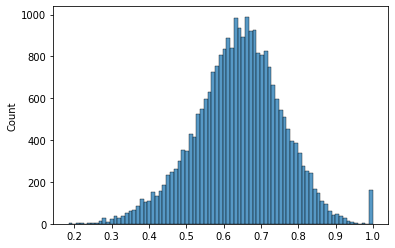

In [8]:
# global-kernel CKA
mat_pairwise = np.fromiter(
    (kernel_CKA(*pair, device='cpu').item() for pair in product(reprs[0].squeeze(), repeat=2)),
    dtype=float
)
sns.histplot(mat_pairwise)
plt.show()

affinity = mat_pairwise.reshape(160,-1)
sns.heatmap(affinity)
plt.show()

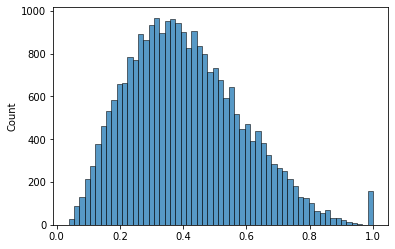

In [10]:
# global-linear CKA
mat_pairwise = np.fromiter(
    (linear_CKA(*pair, device='cpu').item() for pair in product(reprs[0].squeeze(), repeat=2)),
    dtype=float
)
sns.histplot(mat_pairwise)
plt.show()

affinity = mat_pairwise.reshape(160,-1)
sns.heatmap(affinity)
plt.show()

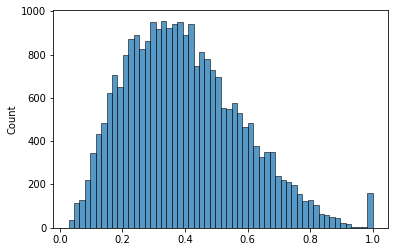

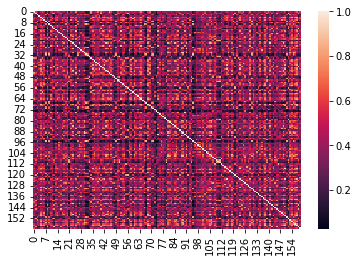

In [15]:
# local0-kernel CKA
mat_pairwise = np.fromiter(
    (linear_CKA(*pair, device='cpu').item() for pair in product(reprs[0].squeeze(), repeat=2)),
    dtype=float
)
sns.histplot(mat_pairwise)
plt.show()

affinity = mat_pairwise.reshape(160,-1)
sns.heatmap(affinity)
plt.show()

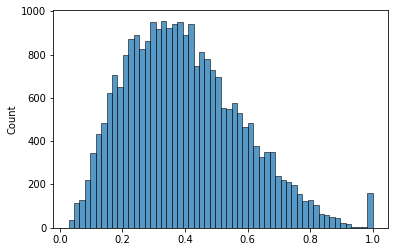

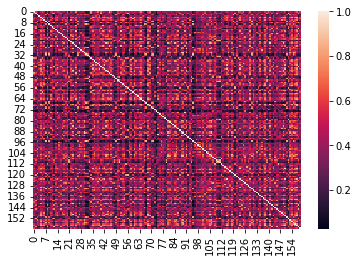

In [16]:
# local0-linear CKA
mat_pairwise = np.fromiter(
    (linear_CKA(*pair, device='cpu').item() for pair in product(reprs[0].squeeze(), repeat=2)),
    dtype=float
)
sns.histplot(mat_pairwise)
plt.show()

affinity = mat_pairwise.reshape(160,-1)
sns.heatmap(affinity)
plt.show()

In [17]:
from sklearn.cluster import SpectralClustering, KMeans
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh

# eigen decomposition for determining number of clusters by eigen gap heuristic
def eigen_decomposition(A, plot=True):
    L = csgraph.laplacian(A, normed=True)
    n_components = A.shape[0]
    eigenvalues, eigenvectors = eigsh(L, k=n_components, which='LM', sigma=1, maxiter=100)
#     eigenvalues, eigenvectors = eigh(L, k=n_components, which='LM', sigma=1.0, maxiter=5000)
    if plot:
        plt.title('Largest eigenvalues of matrix')
        plt.scatter(np.arange(len(eigenvalues)), eigenvalues)
        plt.grid()
    largest_gap_idx = np.argmax(np.diff(eigenvalues))
    n_clusters = largest_gap_idx+2
    return n_clusters, eigenvalues, eigenvectors

2

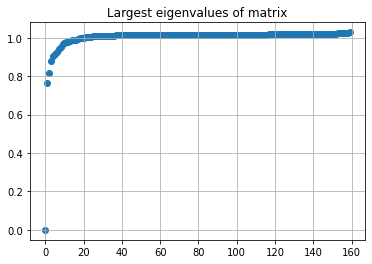

In [19]:
n_clusters, _, _ = eigen_decomposition(affinity)
n_clusters

In [20]:
spec = SpectralClustering(n_clusters=16, affinity='precomputed')

In [21]:
clusters = spec.fit_predict(affinity)
clusters

array([ 2, 10,  2,  5,  5, 10,  2, 11, 12, 11,  1,  5,  0,  4,  1, 15,  0,
        9,  3,  4,  3,  6,  9,  3, 13,  1, 11,  3,  2,  9,  3, 11, 11,  6,
       10,  5, 14,  5,  2,  5,  0,  1,  5,  3, 12,  1,  3,  4,  6, 11,  6,
        6,  1,  2, 14, 10, 10, 15, 12, 10,  2, 14, 13,  2,  1,  9,  3, 11,
        3,  5, 11, 11, 13,  7,  1,  2, 15,  4, 15,  6,  3,  3,  9, 12,  3,
        2,  1, 10,  3,  3,  1,  3, 10, 14,  6, 11, 15,  4, 15,  2,  4,  2,
        4, 15, 14,  3,  3,  4,  3,  6,  6,  6,  8, 14,  9,  5,  3,  9,  3,
        2, 10, 11,  9,  5,  0,  2,  4,  9,  2,  1, 11,  3,  4, 15,  4, 12,
        2, 14,  2,  6,  9,  3,  0,  5,  3,  0,  8, 12,  1,  3,  5, 11,  6,
        2, 14,  3,  4,  5,  0,  9], dtype=int32)

In [22]:
np.fill_diagonal(affinity, 0)

In [35]:
i=12
print(max(affinity[i]))
print(clusters[i])
clusters[np.argmax(affinity[i])]

0.9146679639816284
0


0